# Investigation of two weeks worth of mean response times: Scenario 1

### 1) How much has the mean response time (specifically, the mean of the response times for each individual request) changed from week 1 to week 2?

##### Thoughts:
It looks like there was some anomalous behavior around time 800000 and 1100000 week two. 

We'll get more into this in question 3

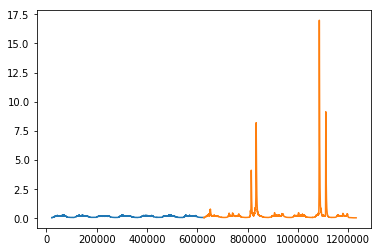

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as st

df = pd.read_csv('scenario1.txt', sep='\t', index_col=0,
                 names=['requests_processed', 'mean_response_time'])

one = df[df.index < 626400]
two = df[df.index >= 626400]

plt.plot(one.index, pd.ewma(one['mean_response_time'], halflife=1000), label='Week One');
plt.plot(two.index, pd.ewma(two['mean_response_time'], halflife=1000), label='Week Two');

##### Answer

To calculate how much the mean response time (for each response) changed from week 1 to week 2 I first need to calculate the mean response time for each response. 

`mean_response_time` can be multiplied by `requests_processed` elementwise and then we can divide by the sum of the total number of requests processed to get the actual `mean_response_time` of all requests over a period of time. It's kind of like calculating a weighted mean. 

In [2]:
def weighted_mean_response_time(df):
    return (df['requests_processed'] * df['mean_response_time']).sum()/\
                df['requests_processed'].sum()

    
def weight_mean_response_times(df):
    return df['requests_processed'] / df['requests_processed'].sum()

In [3]:
difference = weighted_mean_response_time(two) - weighted_mean_response_time(one)
print('The difference between first week and the second week approximately is: ~{:.2f}'.format(
difference))

The difference between first week and the second week approximately is: ~0.28


### 2) Create a plot illustrating the probability distribution of the amount of server time it takes to process a request (excluding the time the request spends waiting in the queue). How would you describe the distribution?

##### Answer
At first glance (**First Illustration of Distribution**), this looks like some insanely skewed longtail. 

But at second glance (**Second Illustration of Distribution**), I've ignored the obvious outliers and you see something that is close to a lognormal distribution or similar (erlang, poisson, etc.).

**Looks like something close to a Lognormal distribution**

##### First Illustration of Distribution

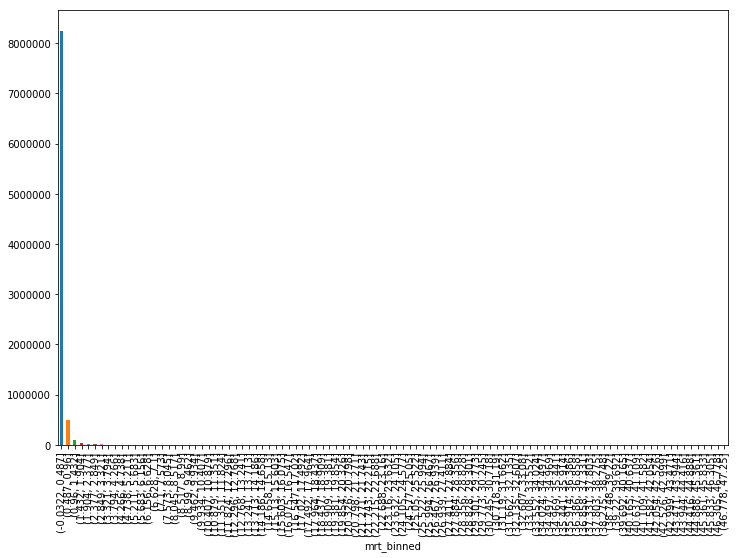

In [4]:
df['mrt_binned'] = pd.cut(df['mean_response_time'], 100)

thing = df.groupby('mrt_binned')['requests_processed'].sum()
thing.plot(kind='bar', figsize=(12, 8))

##### Second Illustration of Distribution

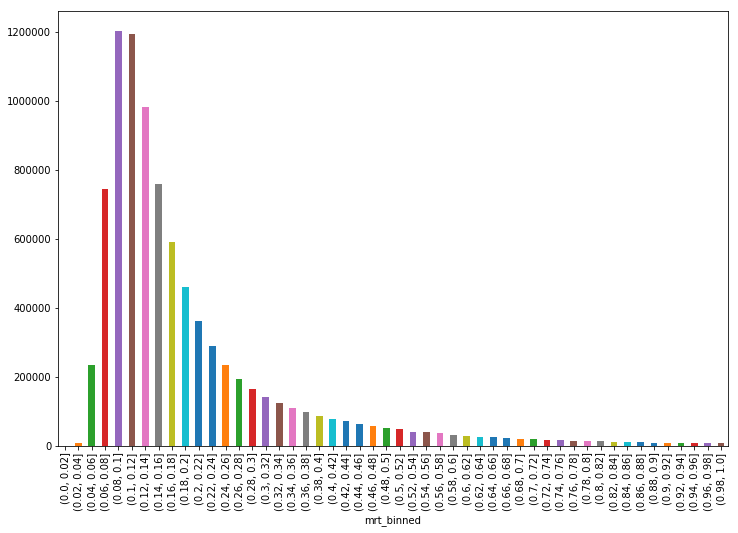

In [5]:
outlier_threshold = 1
df_no_outliers = df[df['mean_response_time'] < outlier_threshold]

df_no_outliers['mrt_binned'] = pd.cut(df_no_outliers['mean_response_time'],
                                      np.linspace(0, outlier_threshold, 51))

mrt_binned = df_no_outliers.groupby('mrt_binned')['requests_processed'].sum()
mrt_binned.plot(kind='bar', figsize=(12, 8))

### 3) Propose a potential cause for the change in response times. Give both a qualitative answer as if you were explaining it to a client and a quantitative answer as if you were explaining it to a statistician. Create 1 or 2 plots to support and illustrate your argument.


### Qualitative Answer to Client:

It appears that week two had some anomalous differences from week one. 

It would be good to find out anything else that was going on in your company during the anomalous periods as there is little that I can explain here except that they were anomalous. The timestamps are there though, perhaps you can go back through your deployment logs and see if there were any major changes or outages during the time stamps of interest. (please see **figure B**)

Excluding the anomalous data, it appears that there is also a significant difference in mean response times between week one and week two. It would be good to understand what changes, if any, you have made between week one and week two: Were there any infrastructure changes? (load balancers, switches, routers, code changes etc.)

It's currently not known if the anomalous data and the significant difference in mean response times are related. Perhaps, if you cannot find anything pertinent in your recent changes near the times of the anomalies, then they might be partly caused by the same changes that have resulted in significant differences in the mean response times between week one and week two. 

### Quantitative Answer for Statistician


It appears that week two had some anomalous differences from week one. 

**Outliers**

We fit a Log-Normal distribution (**see figure A**) to the time series data. (**please see Appendix: Deciding-Gamma-or-LogNormal?**) for more details on how I settled on Log-Normal. This distribution was used to decide what is an outlier. If a data point is outside of where 99% of the data would fall, it was considered an outlier. 

Upper and lower bounds are plotted in the time domain based on this distribution for the same 99% of the data. In these plots (**see Figures B**) it's obvious where the outliers are. (it's kind of obvious already, but now we have an actual number to filter with)

**Significant Difference week one and two means Z-test (sanity check)**

Finally, we are also interested in quantifying if there is a significant difference in mean response times between week one and week two. At least visually, it seems like week 2 has a visually higher mean and variance even ignoring the anomalies. We perform a Z-test (**see Figure C**) We can see that the difference is not significant **(p = .4)**. 

### Figure A

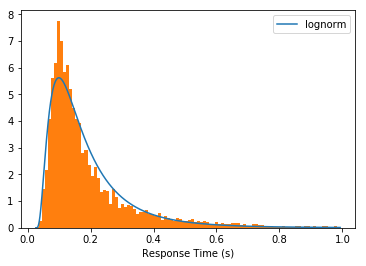

In [6]:
mrt = df[df['mean_response_time'] < 1]
weights = weight_mean_response_times(mrt)

# sub_sample = np.random.choice(restored_no_outliers, 10000)
sub_sample = np.random.choice(mrt['mean_response_time'], 10000, p=weights)
linspace = np.linspace(sub_sample.min(),
                       sub_sample.max(),
                       len(sub_sample))

fit_alpha, fit_loc, fit_beta = st.lognorm.fit(sub_sample)
fitted_lognorm = st.lognorm.freeze(fit_alpha, fit_loc, fit_beta)

fit = fitted_lognorm.pdf(linspace)
plt.plot(linspace, fit, label='lognorm')
plt.hist(sub_sample, normed=True, bins=100)
plt.xlabel('Response Time (s)')
plt.legend(loc='best');
plt.show();

### Figures B
### 99% Distribution of Data in time domain

In [8]:
def plot_proba(one, title=None, upper_bound=.995, lower_bound=.005):
    plt.plot(one.index, pd.ewma(one['mean_response_time'], halflife=1000))
    plt.hlines(fitted_lognorm.ppf(upper_bound),
               one.index.min(),
               one.index.max())
    plt.hlines(fitted_lognorm.ppf(lower_bound),
               one.index.min(),
               one.index.max())
    plt.fill_between(one.index, fitted_lognorm.ppf(upper_bound),
                     fitted_lognorm.ppf(lower_bound),
                     label='{:.0f}% of data'.format((upper_bound - lower_bound)*100),
                     alpha=.1)
    plt.legend(loc='best')
    plt.ylim((0, 5))
    plt.ylabel('Response Time')
    plt.xlabel('Time (s)')
    plt.title(title)

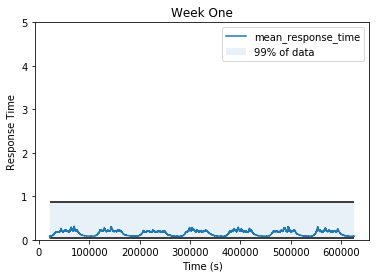

In [9]:
plot_proba(one, 'Week One')

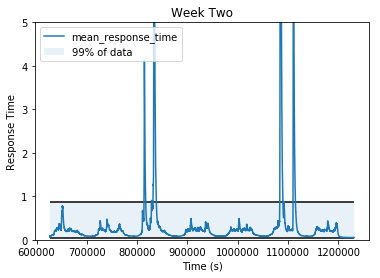

In [10]:
plot_proba(two, 'Week Two')

### Figure C

Significantly different behavior between week one and week two excluding outliers. 

Bootstrapping the Z-test since I can't remember how to do test statistic for non-normal distribution

Z_score: -0.3362632702435512
p-value: ~0.3683


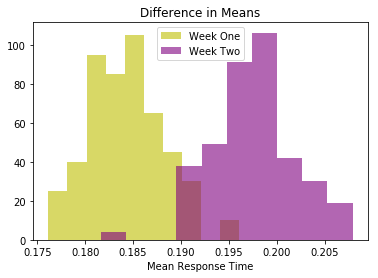

In [11]:
upper_bound_99 = fitted_lognorm.ppf(.995)

one_restored = df[df.index < 626400]
one_weights = weight_mean_response_times(one_restored)
two_restored = df[df.index >= 626400]
two_weights = weight_mean_response_times(two_restored)

two_restored_no_outliers = \
    two_restored[two_restored['mean_response_time'] < upper_bound_99]
two_outliers_weights = weight_mean_response_times(two_restored_no_outliers)


one_means = []
two_means = []
for i in range(100):
    one_means.append(
        np.mean(
            np.random.choice(
                one_restored['mean_response_time'],
                1000,
                p=one_weights)))
    two_means.append(
        np.mean(
            np.random.choice(
                two_restored_no_outliers['mean_response_time'],
                1000,
                p=two_outliers_weights)))

one_means, two_means = np.array(one_means), np.array(two_means)
    
plt.hist(one_means, color='y', bins=10,
         alpha=.6, label='Week One', normed=True)
plt.hist(two_means, color='purple', bins=10,
         alpha=.6, label='Week Two', normed=True)
plt.xlabel('Mean Response Time')
plt.title('Difference in Means')
plt.legend(loc='best');



# bootstrapping z-test by creating samples of mean
pooled_std = np.sqrt((one_means.var() * one_means.shape[0]) +\
        (two_means.var() * two_means.shape[0])\
    /(one_means.shape[0] + two_means.shape[0]))

z_score = (one_means.mean() - two_means.mean())/pooled_std
p_value = st.norm.cdf(z_score)
print("Z_score: {}".format(z_score))
print("p-value: ~{:.4f}".format(p_value))

# Appendix

### Deciding Gamma or LogNormal?

From the samples below, it appears that Lognormal is a reasonable distribution to assume. 

Now I can use this distribution to make parametric estimates of probability. (I could have done this empircally too). 

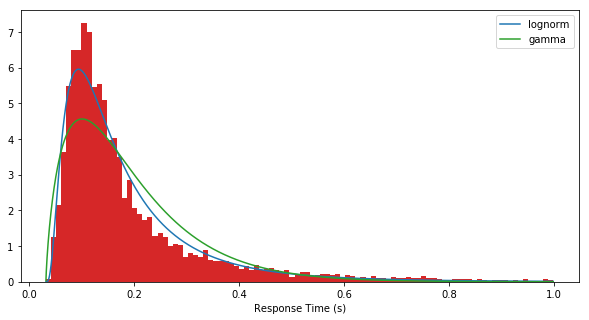

In [66]:
plt.figure(figsize=(10, 5))    
sub_sample = np.random.choice(mrt['mean_response_time'], 10000, p=weights)
results = {}
for dist in [st.lognorm, st.gamma]:
    fit_alpha, fit_loc, fit_beta = dist.fit(sub_sample)

    linspace = np.linspace(sub_sample.min(),
                           sub_sample.max(),
                           len(sub_sample))
    fit = dist.pdf(linspace,
                   fit_alpha,
                   fit_loc,
                   fit_beta)
    results[dist.name] = {'alpha': fit_alpha,
                          'loc': fit_loc,
                          'beta': fit_beta}
    plt.plot(linspace, fit, label=dist.name)
    plt.hist(sub_sample, normed=True, bins=100)
    plt.xlabel('Response Time (s)')
    plt.legend(loc='best');
#     plt.show();

Log normal looks like the better fit here. 